# VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE

## 学習データ作成

In [2]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
# data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 2000, 1024, 1)
data, ori_data, test_data , anomaly_data= Dataset.read_Auged_traindata("sample_data", "sample_test", 2000, 1024, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (2000, 1024, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル作成

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

## モデル作成

## モデル学習

In [4]:
#netよう
z_dim = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modelVAE.VAE_cnn_drop_net(z_dim, device).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
input_data = torch.from_numpy(data.astype(np.float32)).clone()
ori_data = torch.from_numpy(ori_data.astype(np.float32)).clone()
input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()

model.train()
loss_list = []
cnt = 0
# input_data = input_data[0:300]
for epoch in input_data:
    losses = []
    cnt += 1
    for x in epoch:
        x = x.to(device) # データをGPUにのせる
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(cnt, np.average(losses)))
    # for x in input_test_data:
    #     KL_loss, reconstruction_loss = model.loss(x)
    #     loss = KL_loss + reconstruction_loss
    #     losses_val.append(loss.cpu().detach().numpy())

    # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
    #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

EPOCH: 1 loss: 107.38855743408203
EPOCH: 2 loss: 91.68809509277344
EPOCH: 3 loss: 93.56925964355469
EPOCH: 4 loss: 88.55117797851562
EPOCH: 5 loss: 85.3164291381836
EPOCH: 6 loss: 89.52970123291016
EPOCH: 7 loss: 91.30227661132812
EPOCH: 8 loss: 87.25357818603516
EPOCH: 9 loss: 91.67256164550781
EPOCH: 10 loss: 88.18081665039062
EPOCH: 11 loss: 81.89027404785156
EPOCH: 12 loss: 87.00556182861328
EPOCH: 13 loss: 90.7572021484375
EPOCH: 14 loss: 85.32018280029297
EPOCH: 15 loss: 85.28849792480469
EPOCH: 16 loss: 89.43922424316406
EPOCH: 17 loss: 88.29017639160156
EPOCH: 18 loss: 89.05844116210938
EPOCH: 19 loss: 85.22708129882812
EPOCH: 20 loss: 82.73046875
EPOCH: 21 loss: 88.12335205078125
EPOCH: 22 loss: 88.10054016113281
EPOCH: 23 loss: 88.93809509277344
EPOCH: 24 loss: 88.06584930419922
EPOCH: 25 loss: 88.94601440429688
EPOCH: 26 loss: 85.46337890625
EPOCH: 27 loss: 88.88623809814453
EPOCH: 28 loss: 86.88642120361328
EPOCH: 29 loss: 87.96109008789062
EPOCH: 30 loss: 87.68011474609375

KeyboardInterrupt: 

In [ ]:
# z_dim = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = modelVAE.VAE_cnn(z_dim, device).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# input_data = torch.from_numpy(data.astype(np.float32)).clone()
# input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
# for epoch in input_data:
#     losses = []
#     KL_losses = []
#     reconstruction_losses = []
#     model.train()
#     for x in epoch:
#         x = x.to(device)
#         model.zero_grad()
#         KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
#         loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.detach().numpy())
#         KL_losses.append(KL_loss.detach().numpy())
#         reconstruction_losses.append(reconstruction_loss.detach().numpy())

#     losses_val = []
#     model.eval()
#     # for x in input_test_data:
#     #     KL_loss, reconstruction_loss = model.loss(x)
#     #     loss = KL_loss + reconstruction_loss
#     #     losses_val.append(loss.cpu().detach().numpy())

#     # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
#     #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [ ]:
# model_name = "vaemodel"
# ModelEdit = mainmodel.Modeledit("syuron")
# ModelEdit.save_model(model, model_name) 

## 確認だよーん

tensor([[[0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529,
          0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1026, 0.0887,
          0.0718, 0.0723, 0.0731, 0.0770, 0.0783, 0.0822, 0.0827, 0.0834,
          0.0708, 0.0667, 0.0626, 0.0632, 0.0640, 0.0550, 0.0520, 0.0496,
          0.0501, 0.0510, 0.0513, 0.0513, 0.0533, 0.0539, 0.0547, 0.0590,
          0.0604, 0.0648, 0.0654, 0.0662, 0.0583, 0.0556, 0.0535, 0.0541,
          0.0549, 0.0552, 0.0551, 0.0571, 0.0577, 0.0585, 0.0633, 0.0649,
          0.0696, 0.0702, 0.0710, 0.0892, 0.0964, 0.1104, 0.1108, 0.1113,
          0.1073, 0.1059, 0.1049, 0.1053, 0.1059, 0.1287, 0.1376, 0.1529,
          0.1529, 0.1529, 0.1111, 0.0989, 0.0836, 0.0841, 0.0848, 0.0884,
          0.0895, 0.0931, 0.0935, 0.0942, 0.0827, 0.0789, 0.0749, 0.0755,
          0.0762, 0.0745, 0.0738, 0.0745, 0.0751, 0.0758, 0.0754, 0.0751,
          0.0765, 0.0771, 0.0778, 0.0857, 0.0885, 0.0948, 0.0952, 0.0959,
          0.0910, 0.0892, 0.0882, 0.08

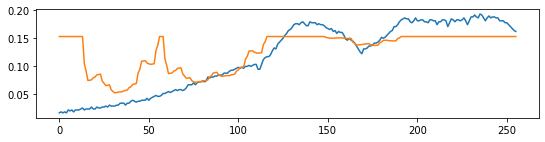

normal:8.018423745408654


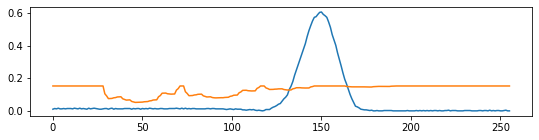

anomarly:34.42526326701045
anomaly
<class 'torch.Tensor'>


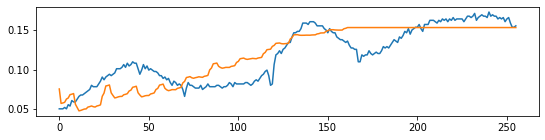

normal:4.4559884667396545


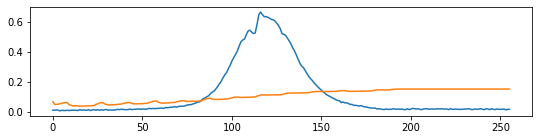

anomarly:33.29663723707199
anomaly
<class 'torch.Tensor'>


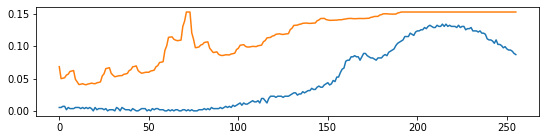

normal:17.11331594362855
anomaly


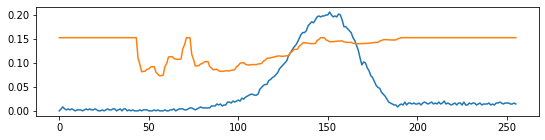

anomarly:25.606136959046125
anomaly
<class 'torch.Tensor'>


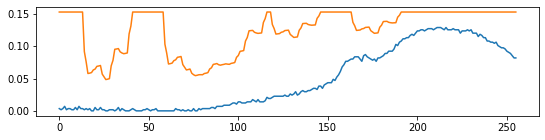

normal:19.64040455967188
anomaly


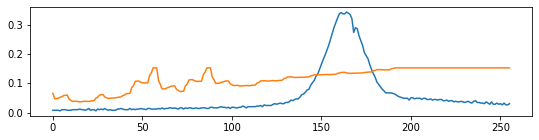

anomarly:22.017496237531304
anomaly
<class 'torch.Tensor'>


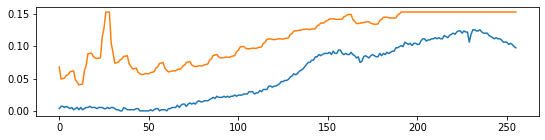

normal:14.632265999913216
anomaly


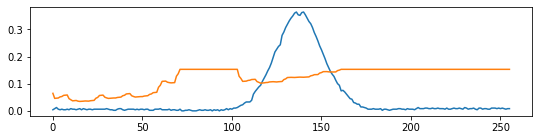

anomarly:28.515249693766236
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [5]:
# num = 5
data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
data0 = data0[np.newaxis, np.newaxis, :]
loss, z, recon = model(data0, device)
# recon, _ = model(data0)
recon = recon.detach()
print(recon)

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        input_data = data0[np.newaxis, np.newaxis, :]
        # recon,_ = model(input_data)
        loss, z, recon = model(input_data, device)
        recon = recon.detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        input_data = test0[np.newaxis, np.newaxis, :]
        # recon,_ = model(input_data)
        loss, z, recon = model(input_data, device)
        recon = recon.detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))
model.eval()
for r in range(3):
    for c in range(5):
        ax[r,c].imshow(model.decoder(torch.randn(10).cuda()).detach().cpu().numpy().reshape(28,28), cmap="gray")
        ax[r,c].axis("off")